In [246]:
from problexity import ComplexityCalculator, classification
from problexity.classification import *
from sklearn.decomposition import PCA
import numpy as np
from generator.ConditionalEvidenceStream import ConditionalEvidenceStream
from generator.concepts import concept_proba
from generator.utils import make_condition_map, mix_to_factor
import torch
import torchvision
import json

np.random.seed(1223)
torch.manual_seed(15553)
torch.set_num_threads(1)

# Prepare stream data
stream_data = torchvision.datasets.MNIST('./files/', 
                                  train=True,
                                  download=True)

X = torch.tensor(stream_data.data)/255
y = stream_data.targets.numpy()

# classes = [1,7]
classes = [2,7]
mask = np.zeros_like(y).astype(bool)
for c in classes:
    mask[y==c] = 1

X = X[mask]    
y = y[mask]   

for c_id, c in enumerate(classes):
    y[y==c] = c_id


/var/folders/md/9788g9qs5h77d4hrzh39xpkc0000gn/T/ipykernel_63342/1973239694.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(stream_data.data)/255


In [247]:

X_pca = PCA(n_components=0.9).fit_transform(X.reshape(X.shape[0],-1))
X_pca -= np.mean(X_pca, axis=0)
X_pca /= np.std(X_pca, axis=0)



In [248]:

# setup
n_chunks = 500
chunk_size = 150

# One stream

factor = mix_to_factor(X_pca)

condition_map = make_condition_map(n_cycles=3,
                                n_concepts=100,
                                factor=factor,
                                factor_range=(0.1,0.9))

cp = concept_proba(n_concepts=100,
                            n_chunks=n_chunks,
                            normalize=True,
                            mode = 'linear')

stream = ConditionalEvidenceStream(X, y,
                                condition_map.T,
                                cp,
                                chunk_size=chunk_size,
                                fragile=False,
                                random_state=1223)



In [249]:

examples = []
complexities=[]

pca = PCA(n_components=0.7)

for c in range(n_chunks):
    _X, _y = stream.get_chunk()
    
    examples.append(_X[:10].numpy())

    if c==0:
        _X = pca.fit_transform(_X.reshape(chunk_size, -1) , _y)    
    
    if c>0:
        _X = pca.transform(_X.reshape(chunk_size, -1))
        complexities.append([f1(_X, _y), n2(_X, _y), n1(_X, _y)])



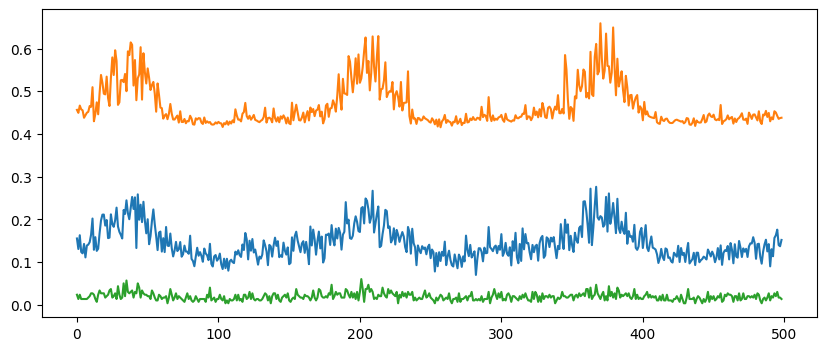

In [250]:
import matplotlib.pyplot as plt


comp = np.array(complexities)

fig, ax = plt.subplots(1,1,figsize=(10,4))
for aa in range(comp.shape[1]):
    ax.plot(comp[:,aa])


In [251]:
examples = np.array(examples)
print(examples.shape)

(500, 10, 28, 28)


In [252]:
com_m = np.mean(comp, axis=1)

simplest = np.argmin(com_m)
hardest = np.argmax(com_m)

print(simplest, hardest)

253 367


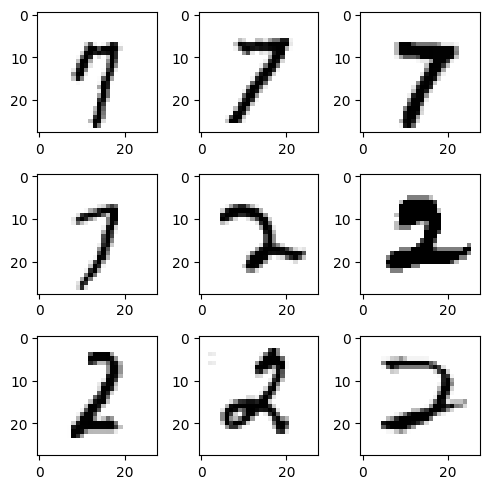

In [253]:
fig, ax = plt.subplots(3,3,figsize=(5,5))
ax = ax.ravel()

for a in range(9):
    ax[a].imshow(examples[simplest,a], cmap='binary')
    
plt.tight_layout()


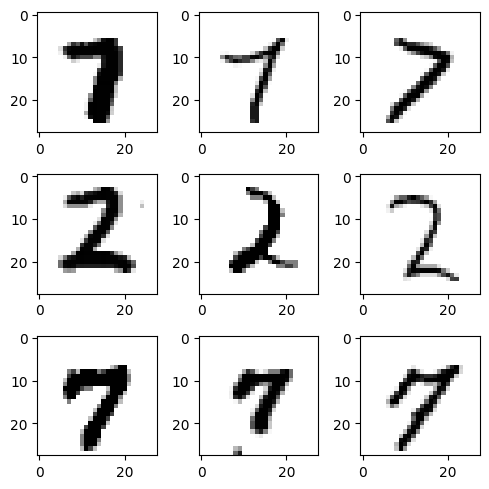

In [254]:
fig, ax = plt.subplots(3,3,figsize=(5,5))
ax = ax.ravel()

for a in range(9):
    ax[a].imshow(examples[hardest,a], cmap='binary')
    
plt.tight_layout()


In [258]:
factor = mix_to_factor(X_pca)

condition_map = make_condition_map(n_cycles=3,
                                n_concepts=100,
                                factor=factor,
                                factor_range=(0.1,0.9))

cp = concept_proba(n_concepts=100,
                            n_chunks=n_chunks,
                            normalize=True,
                            mode = 'linear')

stream = ConditionalEvidenceStream(X, y,
                                condition_map.T,
                                cp,
                                chunk_size=chunk_size,
                                fragile=False,
                                random_state=1223)


In [259]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import balanced_accuracy_score

accs=[]
clf = MLPClassifier(hidden_layer_sizes=(10))

aggregate_x = []
aggregate_y = []

for c in range(n_chunks):
    _X, _y = stream.get_chunk()
    
    if c<10:
        aggregate_x.append(_X.numpy())
        aggregate_y.append(_y)
        
    if c==10:
        aggregate_x = np.array(aggregate_x)
        aggregate_y = np.array(aggregate_y)
        # print(aggregate_x.shape)
        # break
        clf.fit(aggregate_x.reshape(chunk_size*10, -1), aggregate_y.reshape(chunk_size*10))
    
    if c>10:
        accs.append(balanced_accuracy_score(_y, clf.predict(_X.reshape(chunk_size, -1))))
        


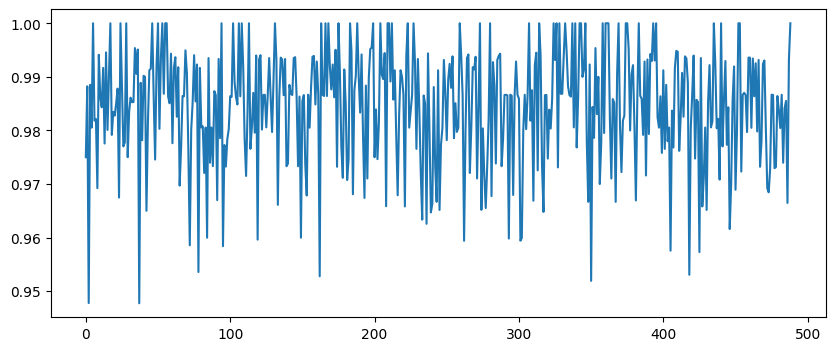

In [260]:
fig, ax = plt.subplots(1,1,figsize=(10,4))
ax.plot(accs)